### Expected Goals including player positions
Step-by-step walk thru of making an expected goals model leveraging additional information concerning opposition player location. This tutorial follows similar design choices as Javier Fernandez’s expected goals model in "A framework for the fine-grained evaluation of the instantaneous expected value of soccer possessions.

This effort will train a shallow neural network with following features:

- ball location (x)
- binary variable signifying if ball was closer to the goal than the opponent’s goalkeeper
- angle between the ball and the goal
- distance between the ball and the goal
- distance between the ball and the goalkeeper in y-axis
- distance between the ball and the goalkeeper
- number of opponent players inside the triangle formed between the ball location and opponent’s goal posts
- number of opponent players less than 3 meters away from the ball location
- binary variable signifying if shot was a header
- expected goals based on distance to goal and angle between the ball and the goal

In [1]:
from pathlib import Path

In [2]:
#importing necessary libraries
from mplsoccer import Sbopen
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import random as rn
import tensorflow as tf
#warnings not visible on the course webpage
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

2024-01-10 20:31:25.229794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#setting random seeds so that the results are reproducible on the webpage

os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Opening data
This task will use Statsbomb Indian Super League 2021/2022 data since it is the only dataset openly available that **contains both event and tracking data** for the entire season. Open each game and store data for the entire season in dataframes shot_df and track_df. Then change yards to meters. In the end, filter open play shots and remove shots without the goalkeeper tracked.

In [4]:
parser = Sbopen()
#get list of games during Indian Super League season
df_match = parser.match(competition_id=1238, season_id=108)
matches = df_match.match_id.unique()
matches[:10]

array([3827767, 3827335, 3827336, 3827338, 3827337, 3817856, 3817891,
       3817870, 3817899, 3817866])

In [5]:
file1 = Path('./shot_df_xGpos.csv')
file2 = Path('./track_df_xGpos.csv')
if file1.is_file() and file2.is_file():
    print('files are there')

files are there


In [6]:

file1 = Path('./shot_df_xGpos.csv')
file2 = Path('./track_df_xGpos.csv')
if file1.is_file() and file2.is_file():
    shot_df = pd.read_csv('shot_df_xGpos.csv')
    track_df = pd.read_csv('track_df_xGpos.csv')
else:
    shot_df = pd.DataFrame()
    track_df = pd.DataFrame()
    #store data in one dataframe
    for match in matches:
        shots = (parser.event(match)[0] # open events
                .query("type_name == 'Shot'") # query shots
                .assign(x = lambda df: df.x.apply(lambda cell: cell*105/120), # assign column updates
                        y = lambda df: df.y.apply(lambda cell: cell*68/80))
                )
        
        df_track = (parser.event(match)[2] # open 360 data
                    .assign(x = lambda df: df.x.apply(lambda cell: cell*105/120), # assign column updates
                            y = lambda df: df.y.apply(lambda cell: cell*68/80)))
        
        #append event and trackings to a dataframe
        shot_df = pd.concat([shot_df, shots], ignore_index = True)
        track_df = pd.concat([track_df, df_track], ignore_index = True)
    # reset indicies
    shot_df.reset_index(drop=True, inplace=True)
    track_df.reset_index(drop=True, inplace=True)

    # filter out non open-play shots
    shot_df = shot_df.query('sub_type_name == "Open Play"')

    #filter out shots where goalkeeper was not tracked
    gks_tracked = track_df.query("teammate == False and position_name == 'Goalkeeper'")['id'].unique()
    shot_df = shot_df.loc[shot_df["id"].isin(gks_tracked)]

In [7]:
shot_df.sample(3)

,Unnamed: 0,id,index,period,timestamp,minute,second,possession,duration,match_id,...,shot_deflected,shot_open_goal,ball_recovery_offensive,pass_miscommunication,player_off_permanent,dribble_no_touch,foul_committed_penalty,foul_won_penalty,shot_follows_dribble,shot_redirect
2158,2331,9bbb8185-7062-43a0-8799-3152959cf926,896,1,00:22:10,22,10,54,1.158561,3813317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1395,1515,9f21f417-17ba-45c9-b7de-4be95d449909,3120,2,00:52:55,97,55,197,1.183715,3817876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1721,1867,7834afb5-e505-4028-9307-0778f636bb22,2383,2,00:27:05,72,5,154,0.243436,3813269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
track_df.sample(3)

,Unnamed: 0,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
17854,17854,False,3817892,0821a975-2be4-4d8d-97ee-942d4bf2206e,87.7625,23.715,24860,Héctor Rodas Ramírez,3,Right Center Back,8
5948,5948,False,3817863,4763d971-6861-4e3d-a862-ae6953ebb7e5,95.2000,23.800,124903,Akash Mishra,6,Left Back,7
40295,40295,False,3813268,058bf268-4f99-405d-85a9-a5a5eba780cf,87.0625,43.435,124756,Subhasish Bose,8,Left Wing Back,3


### Feature engineering - Model data
This section creates features to improve the dataset. They will be stored in a model_vars dataframe. It is suggested to read the code comments to understand this part of tutorial better.  The details are embedded within the code.

In [9]:

model_vars = (shot_df[["id", "index", "x", "y", "outcome_name"]] # take important variables from shot dataframe
              .assign(goal = lambda df: np.where(df.outcome_name=='Goal',1,0),
                      goal_smf = lambda df: df.goal.astype(object),
                      x0 = lambda df: df.x,
                      x = lambda df: df.x.apply(lambda cell: 105-cell),
                      c = lambda df: df.y.apply(lambda cell: 34-cell),
                      angle = lambda df: np.where(np.arctan(7.32 * df.x/((df.x)**2 + (df.c)**2 - (7.32/2)**2)) >= 0, 
                                                  np.arctan(7.32 * df.x/((df.x)**2 + (df.c)**2 - (7.32/2)**2)),
                                                  np.arctan(7.32 * df.x/((df.x)**2 + (df.c)**2 - (7.32/2)**2)) + np.pi*180/np.pi),
                      distance = lambda df: np.sqrt((df.x)**2 + (df.c)**2))
               .drop('outcome_name', axis=1)
            )
# #take important variables from shot dataframe
# model_vars = shot_df[["id", "index", "x", "y"]]
# #get the dependent variable
# model_vars["goal"] = shot_df.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
# #change the dependent variable to object for basic xG modelling
# model_vars["goal_smf"] = model_vars["goal"].astype(object)
# # ball location (x)
# model_vars['x0'] = model_vars.x
# # x to calculate angle and distance
# model_vars["x"] = model_vars.x.apply(lambda cell: 105-cell)
# # c to calculate angle and distance between ball and the goal as in Lesson 2
# model_vars["c"] = model_vars.y.apply(lambda cell: abs(34-cell))
# #calculating angle and distance as in Lesson 2
# model_vars["angle"] = np.where(np.arctan(7.32 * model_vars["x"] / (model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
# model_vars["distance"] = np.sqrt(model_vars["x"]**2 + model_vars["c"]**2)
model_vars.head(10)

,id,index,x,y,goal,goal_smf,x0,c,angle,distance
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713
5,e6c21735-9791-43f8-ac6b-5e18782df505,1360,7.8750,21.165,0,0,97.1250,12.835,0.263880,15.058315
6,7bd0743e-8b06-4292-b33f-1d5cd8bdfa26,1435,26.8625,43.180,0,0,78.1375,-9.180,0.243215,28.387784
7,0498726a-bc2c-4ff9-ae79-7a61a24820f0,1601,8.1375,28.220,0,0,96.8625,5.780,0.604506,9.981348
8,634a3e52-38d5-4804-8904-8005defb69fe,1760,27.3875,39.015,0,0,77.6125,-5.015,0.257318,27.842869
9,41c752ca-0121-4090-a8c1-685a10fa057e,2057,11.6375,41.225,0,0,93.3625,-7.225,0.454739,13.697884


### F1. Basic xG feature calculation
Using logistic regression, a basic expected goals feature will be added to the dataset, which determines the value strictly based on position on the pitch.  The parameters will be determined through a binomial fit for logistic regression.  This was demonstrated in some of the earlier chapters on expected goals, xG.

In [10]:
# calculating basic xG values using logistic regression model
def params(df):
    '''Fit logistic regression model and return parameters
    df = dataframe determined with columns index, x, y, goal, goal_smf, x0, c, angle and distance
    returns = fitted model parameters'''
    test_model = smf.glm(formula="goal_smf ~ angle + distance", data=df, family=sm.families.Binomial()).fit()
    return test_model.params

def calculate_xG(sh, b):
    '''Calculate xG for each of the recorded positions in the dataset at each event
    sh, b = model parameters
    returns = column of calculated xG values based on position on the pitch'''
    bsum=b[0]
    for i,v in enumerate(["angle", "distance"]):
         bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum))
    return xG

# expected goals based on distance to goal and angle between the ball and the goal
b = params(model_vars)
model_vars["xg_basic"]= model_vars.apply(calculate_xG, b = b, axis=1)

In [11]:
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692,0.017714
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628,0.192132
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857,0.037062
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836,0.016754
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713,0.061533


### F2.Ball to Goalkeeper distance
Feature highlighting the distance between the keeper and the ball at the time of the event.

In [12]:

# ball_goalkeeper distance
def dist_to_gk(test_shot, track_df):
    '''Determine the distance to the goal keeper at the time of the shot
    test_shot = record placeholder
    track_df = tracking data dataframe/table
    returns calculated distance to the goal keeper when shooting.'''
    
    # get id of the shot to search for tracking data using this index, taken from shot_df through apply tool
    test_shot_id = test_shot["id"]
    
    # check goalkeeper position at time of shot/event
    gk_pos = (track_df
              .query('id == @test_shot_id and teammate == False and position_name == "Goalkeeper"')[["x", "y"]])

    # calculate distance from event to goalkeeper position
    dist = np.sqrt((test_shot["x"] - gk_pos["x"])**2 + (test_shot["y"] - gk_pos["y"])**2)
    return dist.iloc[0]


In [13]:

# store distance from event to goalkeeper position in a dataframe
model_vars["gk_distance"] = shot_df.apply(dist_to_gk, track_df = track_df, axis = 1)
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic,gk_distance
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692,0.017714,29.555469
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628,0.192132,6.328035
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857,0.037062,22.043447
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836,0.016754,30.327900
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713,0.061533,16.224501


### F3.Goalkeeper distance from Event
This feature will determine how far the event occurs from the goalkeeper in the y dimension. Using the goalkeeper dimension highlights the difficulty of the shot coverage based on the position relative to the shotting angle.  

In [14]:
# ball goalkeeper y axis
def y_to_gk(test_shot, track_df):
    '''The y_to_gk determines the distance from the goal keeper at the time of the shot.
    test shot = shot record being evaluated taken as the [id] passed for the dataframe
    track_df = tracking dataframe used to determine goal keeper and event occurance position.
    returns = distance from the goalkeeper in the y dimension. '''
    # get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # calculate goalkeeper position corresponding to event
    gk_pos = (track_df
              .query('id == @test_shot_id and teammate == False and position_name == "Goalkeeper"')[["y"]]
              )
    
    # calculate distance from event to goalkeeper position in y axis
    dist = abs(test_shot["y"] - gk_pos["y"])
    return dist.iloc[0]

In [15]:

#store distance in y axis from event to goalkeeper position in a dataframe
model_vars["gk_distance_y"] = shot_df.apply(y_to_gk, track_df = track_df, axis = 1)
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic,gk_distance,gk_distance_y
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692,0.017714,29.555469,16.660
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628,0.192132,6.328035,0.595
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857,0.037062,22.043447,6.970
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836,0.016754,30.327900,17.510
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713,0.061533,16.224501,11.305


### F4.Congestion inside three meters
The function below checks the level of congestion at the time of the shooting event. 

In [16]:
def three_meters_away(test_shot, track_df):
    '''Determine the number of players within 3m of the ball possition.
    test_shot = Shot id in question
    track_df = Dataframe of player positions during each event as tracked.
    returns = number of players within 3m'''
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = (track_df
                       .query('id == @test_shot_id and teammate == False and teammate == False')[["x","y"]]
                       )
    #calculate their distance to the ball
    dist = np.sqrt((test_shot["x"] - player_position["x"])**2 + (test_shot["y"] - player_position["y"])**2)
    #return how many are closer to the ball than 3 meters
    return len(dist[dist<3])

In [17]:
#store number of opposition's players closer than 3 meters in a dataframe
model_vars["close_players"] = shot_df.apply(three_meters_away, track_df = track_df, axis = 1)
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic,gk_distance,gk_distance_y,close_players
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692,0.017714,29.555469,16.660,0
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628,0.192132,6.328035,0.595,2
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857,0.037062,22.043447,6.970,1
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836,0.016754,30.327900,17.510,0
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713,0.061533,16.224501,11.305,1


### F.5 Players in a Triangle
How many players are within a triangle determined by the ball position within the field.

In [18]:

#number of players inside a triangle
def players_in_triangle(test_shot, track_df):
    '''Get the number of players within a triangle of space around the ball position at the time of the shot

    test_shot = id of event for the shot
    track_df = dataframe of all player positions at the time of each event indexed by event id.
    returns = number of players within a triangle'''
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = (track_df
                       .query('id == @test_shot_id and teammate == False and teammate == False')[["x","y"]]
                       )
    #checking if point inside a triangle of some size?? not clear
    x1 = 105
    y1 = 34 - 7.32/2
    x2 = 105
    y2 = 34 + 7.32/2
    x3 = test_shot["x"]
    y3 = test_shot["y"]
    xp = player_position["x"]
    yp = player_position["y"]
    c1 = (x2-x1)*(yp-y1)-(y2-y1)*(xp-x1)
    c2 = (x3-x2)*(yp-y2)-(y3-y2)*(xp-x2)
    c3 = (x1-x3)*(yp-y3)-(y1-y3)*(xp-x3)
    #get number of players inside a triangle
    return len(player_position.loc[((c1<0) & (c2<0) & (c3<0)) | ((c1>0) & (c2>0) & (c3>0))])


In [19]:

#store number of opposition's players inside a triangle in a dataframe
model_vars["triangle"] = shot_df.apply(players_in_triangle, track_df = track_df, axis = 1)
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic,gk_distance,gk_distance_y,close_players,triangle
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692,0.017714,29.555469,16.660,0,2
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628,0.192132,6.328035,0.595,2,1
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857,0.037062,22.043447,6.970,1,1
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836,0.016754,30.327900,17.510,0,2
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713,0.061533,16.224501,11.305,1,1


### F.6 Goalkeeper distance to Goal
Determine goalkeeper distance to goal, and then compare to ball distance to determine if the ball is closer increasing the likelihood of a successful finish.  This will add a column for gk_dist_to_goal, is_closer for the ball and if the opportunity was a header (header).

In [20]:

def gk_dist_to_goal(test_shot, track_df):
    '''function to determine the goalkeepers distance to the goal at the time of the shot. Runs against a single record in the dataframe.
    test_shot = dataframe on which the evaluation is conducted
    track_df = position of all players for each recorded event timeframe
    returns = goalkeeper distance to the goal (float)'''
    # get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # get goalkeeper position
    gk_pos = (track_df
              .query("id == @test_shot_id and teammate == False and position_name == 'Goalkeeper'")[["x", "y"]]
            )
    # calculate their distance to goal
    dist = np.sqrt((105 -gk_pos["x"])**2 + (34 - gk_pos["y"])**2)
    return dist.iloc[0]

In [21]:

# store opposition's goalkeeper distance to goal in a dataframe
model_vars["gk_dist_to_goal"] = shot_df.apply(gk_dist_to_goal, track_df = track_df, axis = 1)

# create binary varibale 1 if ball is closer to the goal than goalkeeper
model_vars["is_closer"] = np.where(model_vars["gk_dist_to_goal"] > model_vars["distance"], 1, 0)

# create binary variable 1 if header
model_vars["header"] = shot_df.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)

In [22]:
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic,gk_distance,gk_distance_y,close_players,triangle,gk_dist_to_goal,is_closer,header
0,f4889f42-cf51-4c27-8c8d-d57040b17ce1,368,25.5500,16.150,0,0,79.4500,17.850,0.192795,31.167692,0.017714,29.555469,16.660,0,2,1.646210,0,0
1,3e3c20ab-5233-479f-877e-73b94d01a963,495,7.1750,33.405,0,0,97.8250,0.595,0.938993,7.199628,0.192132,6.328035,0.595,2,1,0.875000,0,1
2,f6fa4021-385f-4353-9e41-81a9ade1d2ac,731,22.8375,41.735,0,0,82.1625,-7.735,0.286239,24.111857,0.037062,22.043447,6.970,1,1,2.071437,0,0
3,3c75ac72-8c43-4ca4-b6f4-2d38dc58c8c7,1069,26.0750,15.980,0,0,78.9250,18.020,0.190229,31.695836,0.016754,30.327900,17.510,0,2,1.408104,0,0
4,49c30b55-a2df-4b6e-84fa-101457ed2d08,1356,13.5625,47.515,0,0,91.4375,-13.515,0.274009,19.146713,0.061533,16.224501,11.305,1,1,2.930823,0,0


### Finalize model target and features
Create a target vector and the feature matrix for the final model.  The engineered features will be used to facilitate the new model implementation.  This will provide the basis for a model which will indicate the likelyhood of a goal occuring at the moment of the event execution, incorporating information about the keeper, opponent spacing and congestion.

In [23]:

#store dependent variable in a numpy array
y = model_vars["goal"].values
#store independent variables in a numpy array
X = model_vars[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values

### Training neural network
With the features created it is now possible to train a neural network. 

1. Split the data 60% training, 20% validation and 20% test. 
2. Scale inputs. 
3. Create a neural network model. It follows similar design choices as Javier Fernandez’s example. 2 dense layers sized 10 followed by a ReLU activation and a final layer size 1 with sigmoid activation to compute the probabilities. This model optimizes the Brier score using Adam optimizer with learning rate 0.001 default betas. 

This implementation uses a suggested early stopping with minimum delta 1e-5 and a batch size of 16. However, it also uses patience equal to 50 to avoid stopping the first time the validation loss does not changing.

In [24]:
# ML Imports

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Split the Data
Break the dataset into a train, test split allowing some to be help back for post training validation.  
- 60% train
- 20% validation (held for final model)
- 20% test 

In [25]:
# spllit the data to train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 123, stratify = y)
X_cal, X_val, y_cal, y_val  = train_test_split(X_test, y_test, train_size = 0.5, random_state = 123, stratify = y_test)

### Scale the data
Avoid overinfluencing the results due to some data being on a different scale from the other features.  An example to example is the difference between angles and distances in the dataset.  One, angles, is in radians while distance is in meters.  The creates a very different impact as all the items are brought together.  The Standard scaler function handles this process from Sklearn.

In [26]:
# scale data
scaler = StandardScaler() # instantiate the scaler, then apply across all the created splits of data
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_cal = scaler.transform(X_cal)

### Create a Model Function
This is done to allow the model to be called with various attempts at hyperparameters.  The tuning process is much easier with the model called through a functions with allows variable range parameters to be employed.

In [27]:
# creating a function with a model architecture
def create_model():
    '''Implement a neural network model with associated architechture or layers.  This is not needed for all model types. 
    Takes specified layers in the sequential call, 2 dense size 10 with RelU
    returns = Instantiated 3 layer untrained model'''
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation = 'sigmoid'),
    ])
    # define model optimizer function
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    # instantiate model based on optimise
    model.compile(optimizer=opt, loss="mean_squared_error" , metrics=['accuracy'])
    return model

>**Note**:  Instantiate the model, the create a diminishing return cut off, and then fit the model using these paramters.

In [28]:
# instantiate the model
model = create_model()
# create an early stopping object
callback = EarlyStopping(min_delta=1e-5, patience = 50, mode = "min", monitor = "val_loss", restore_best_weights=True)
# fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=1, batch_size=16, callbacks = [callback])

Epoch 1/1000
108/108 [==============================] - 4s 11ms/step - loss: 0.1686 - accuracy: 0.8765 - val_loss: 0.1118 - val_accuracy: 0.8974
Epoch 2/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.8974 - val_loss: 0.0928 - val_accuracy: 0.8974
Epoch 3/1000
108/108 [==============================] - 1s 6ms/step - loss: 0.0930 - accuracy: 0.8974 - val_loss: 0.0899 - val_accuracy: 0.8974
Epoch 4/1000
108/108 [==============================] - 1s 7ms/step - loss: 0.0914 - accuracy: 0.8974 - val_loss: 0.0874 - val_accuracy: 0.8974
Epoch 5/1000
108/108 [==============================] - 1s 6ms/step - loss: 0.0905 - accuracy: 0.8974 - val_loss: 0.0854 - val_accuracy: 0.8974
Epoch 6/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0898 - accuracy: 0.8974 - val_loss: 0.0837 - val_accuracy: 0.8974
Epoch 7/1000
108/108 [==============================] - 1s 6ms/step - loss: 0.0891 - accuracy: 0.8974 - val_loss: 0.0824 - val_accuracy

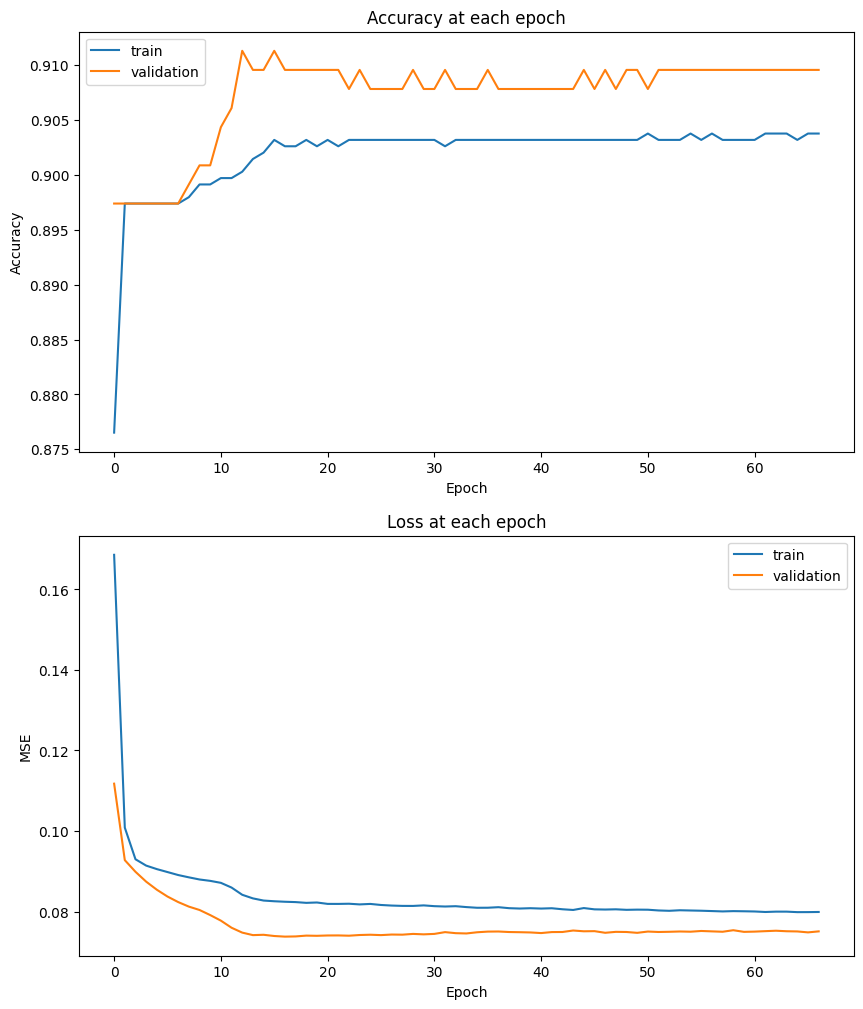

In [29]:
fig, axs = plt.subplots(2, figsize=(10,12))
# plot training history - accuracy
axs[0].plot(history.history['accuracy'], label='train')
axs[0].plot(history.history['val_accuracy'], label='validation')
axs[0].set_title("Accuracy at each epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# plot training history - loss function
axs[1].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='validation')
axs[1].legend()
axs[1].set_title("Loss at each epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("MSE")
plt.show()

### Assessing our model
To assess the model calculate ROC AUC and investigate calibration curves. From the plots it can be seen that some of higher probabilities are underestimated by our model, but these are satisfactory results given the amount of data and the shallowness of the network. 

Also, the calculated Brier score on unseen data supports to validity of the model. It amounts to 0.08, which is a good score.

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve

18/18 [==============================] - 0s 3ms/step


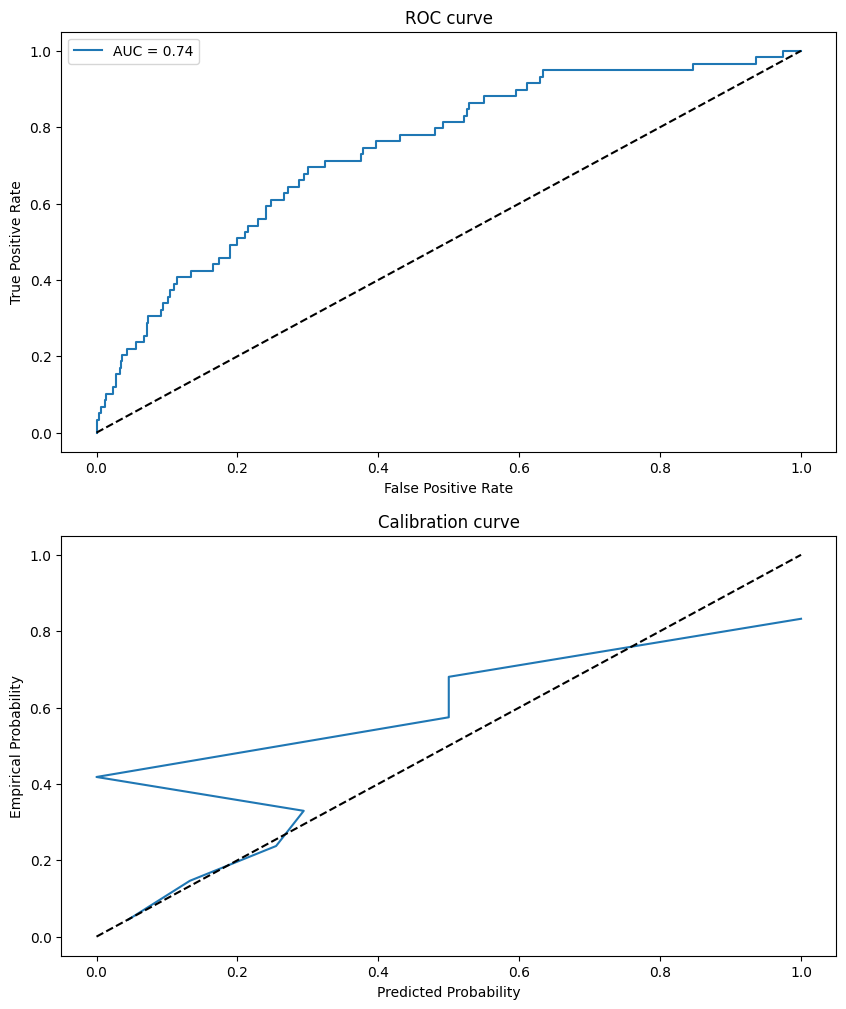

Brier score 0.08441542826537389


In [33]:
# ROC CURVE
fig, axs = plt.subplots(2, figsize=(10,12))
y_pred = model.predict(X_cal)
fpr, tpr, _ = roc_curve(y_cal,  y_pred)
auc = roc_auc_score(y_cal, y_pred)
axs[0].plot(fpr,tpr,label= "AUC = " + str(auc)[:4])
axs[0].plot([0, 1], [0, 1], color='black', ls = '--')
axs[0].legend()
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title('ROC curve')

# CALIBRATION CURVE
prob_true, prob_pred = calibration_curve(y_cal, y_pred, n_bins=10)
axs[1].plot(prob_true, prob_pred)
axs[1].plot([0, 1], [0, 1], color='black', ls = '--')
axs[1].set_ylabel('Empirical Probability')
axs[1].set_xlabel('Predicted Probability')
axs[1].set_title("Calibration curve")
plt.show()
#Brier score
print("Brier score", brier_score_loss(y_cal, y_pred))


### Calculating xG using new model for UEFA Euro 2020
A trained model can now be applied to a dataset of any choice. UEFA Euro 2020 will be the new dataset. First, the data is stored in the same way as for Indian Super League demonstrated above. Then, apply the same data transformations as on the training dataset. As the next step; scale the data and make predictions on them. Then, use the model to find the five players that accumulated the highest open play Expected Goals during the tournament.